In [283]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from matplotlib.dates import date2num
from random import random

from staff.hermes import Hermes
from analysis.indicators import Indicators
from helpers.fibonacci import fibonacci_series

h = Hermes(exchange='binance', mode ='backtest')
i = Indicators()

In [284]:
SYMBOL = 'BTCUSDT'
INTERVAL = '15m'
START = -1000
END = 'November 13, 2022 00:00:00'

MAX_NO_OF_PERIODS = 100

In [285]:
def clean_dataframe(df):
    df.set_index('human open time', inplace=True)
    df.drop(columns=['open time', 'close time', 'volume', 'quote asset volume'], axis=1, inplace=True)
    return df

In [286]:
periods = fibonacci_series(MAX_NO_OF_PERIODS)

query_res = h.get_ohlcv(symbols=SYMBOL, interval=INTERVAL, start=START, end=END)
if query_res['success']:
    ohlcv = clean_dataframe(query_res['message'])

periods 

(1, 2, 3, 5, 8, 13, 21, 34, 55, 89)

In [287]:
from statistics import median


df = pd.DataFrame()
for p in periods:
    df = i.ewma(df=ohlcv, period=p, on_what='close')

atr = i.average_true_range(open_=df['open'], high_=df['high'], low_=df['low'], close_=df['close'], period=13)
atr_smooth = i.average_true_range(open_=df['open'], high_=df['high'], low_=df['low'], close_=df['close'], period=89) # atr.ewm(span=21).mean()
df.drop(columns=['open', 'high', 'low', 'close'], axis=1, inplace=True)
df.dropna(inplace=True)
diffs = df.pct_change(axis=1) * -1
diffs = diffs.ewm(span=13).mean()
sum_diffs = diffs.sum(axis=1)
sum_diffs_smoothed = sum_diffs.ewm(span=34).mean()


In [288]:
s_df = diffs.copy(deep=True)
s_df['sum diffs'] = sum_diffs
s_df['sum diff smooth'] = sum_diffs_smoothed

s_df['atr'] = atr
s_df['atr smooth'] = atr_smooth
s_df['signal'] = 0
# s_df.loc[(s_df['sum diffs'] > s_df['sum diff smooth']) & (s_df['sum diff smooth'] < 0), 'signal'] = 1
# s_df.loc[(s_df['sum diffs'] < s_df['sum diff smooth']) & (s_df['sum diff smooth'] > 0), 'signal'] = -1

s_df.loc[(s_df['sum diffs'] > s_df['sum diff smooth']), 'signal'] = 1
s_df.loc[(s_df['sum diffs'] < s_df['sum diff smooth']), 'signal'] = -1

# s_df.loc[(s_df['atr'] < s_df['atr smooth']) & ~(s_df['signal'] == 0), 'signal'] = 0


s_df.loc[(s_df['signal'] == 1) & ~(s_df['signal'].shift() == 1), 'long open'] = True
s_df.loc[(s_df['signal'] == -1) & ~(s_df['signal'].shift() == -1), 'short open'] = True
s_df.loc[(s_df['signal'] == 0) & ~(s_df['signal'].shift() == 0), 'close position'] = True


# s_df.loc[~(s_df['signal'] == s_df['signal'].shift()), 'switch'] = True
s_df['event.id'] = np.random.rand(len(s_df))
s_df['event.id'] = (s_df['event.id'] * 10000).astype(int)
s_df.loc[(s_df['signal'] == s_df['signal'].shift()), 'event.id'] = np.nan      
s_df['event.id'].ffill(inplace=True)

<AxesSubplot:xlabel='human open time'>

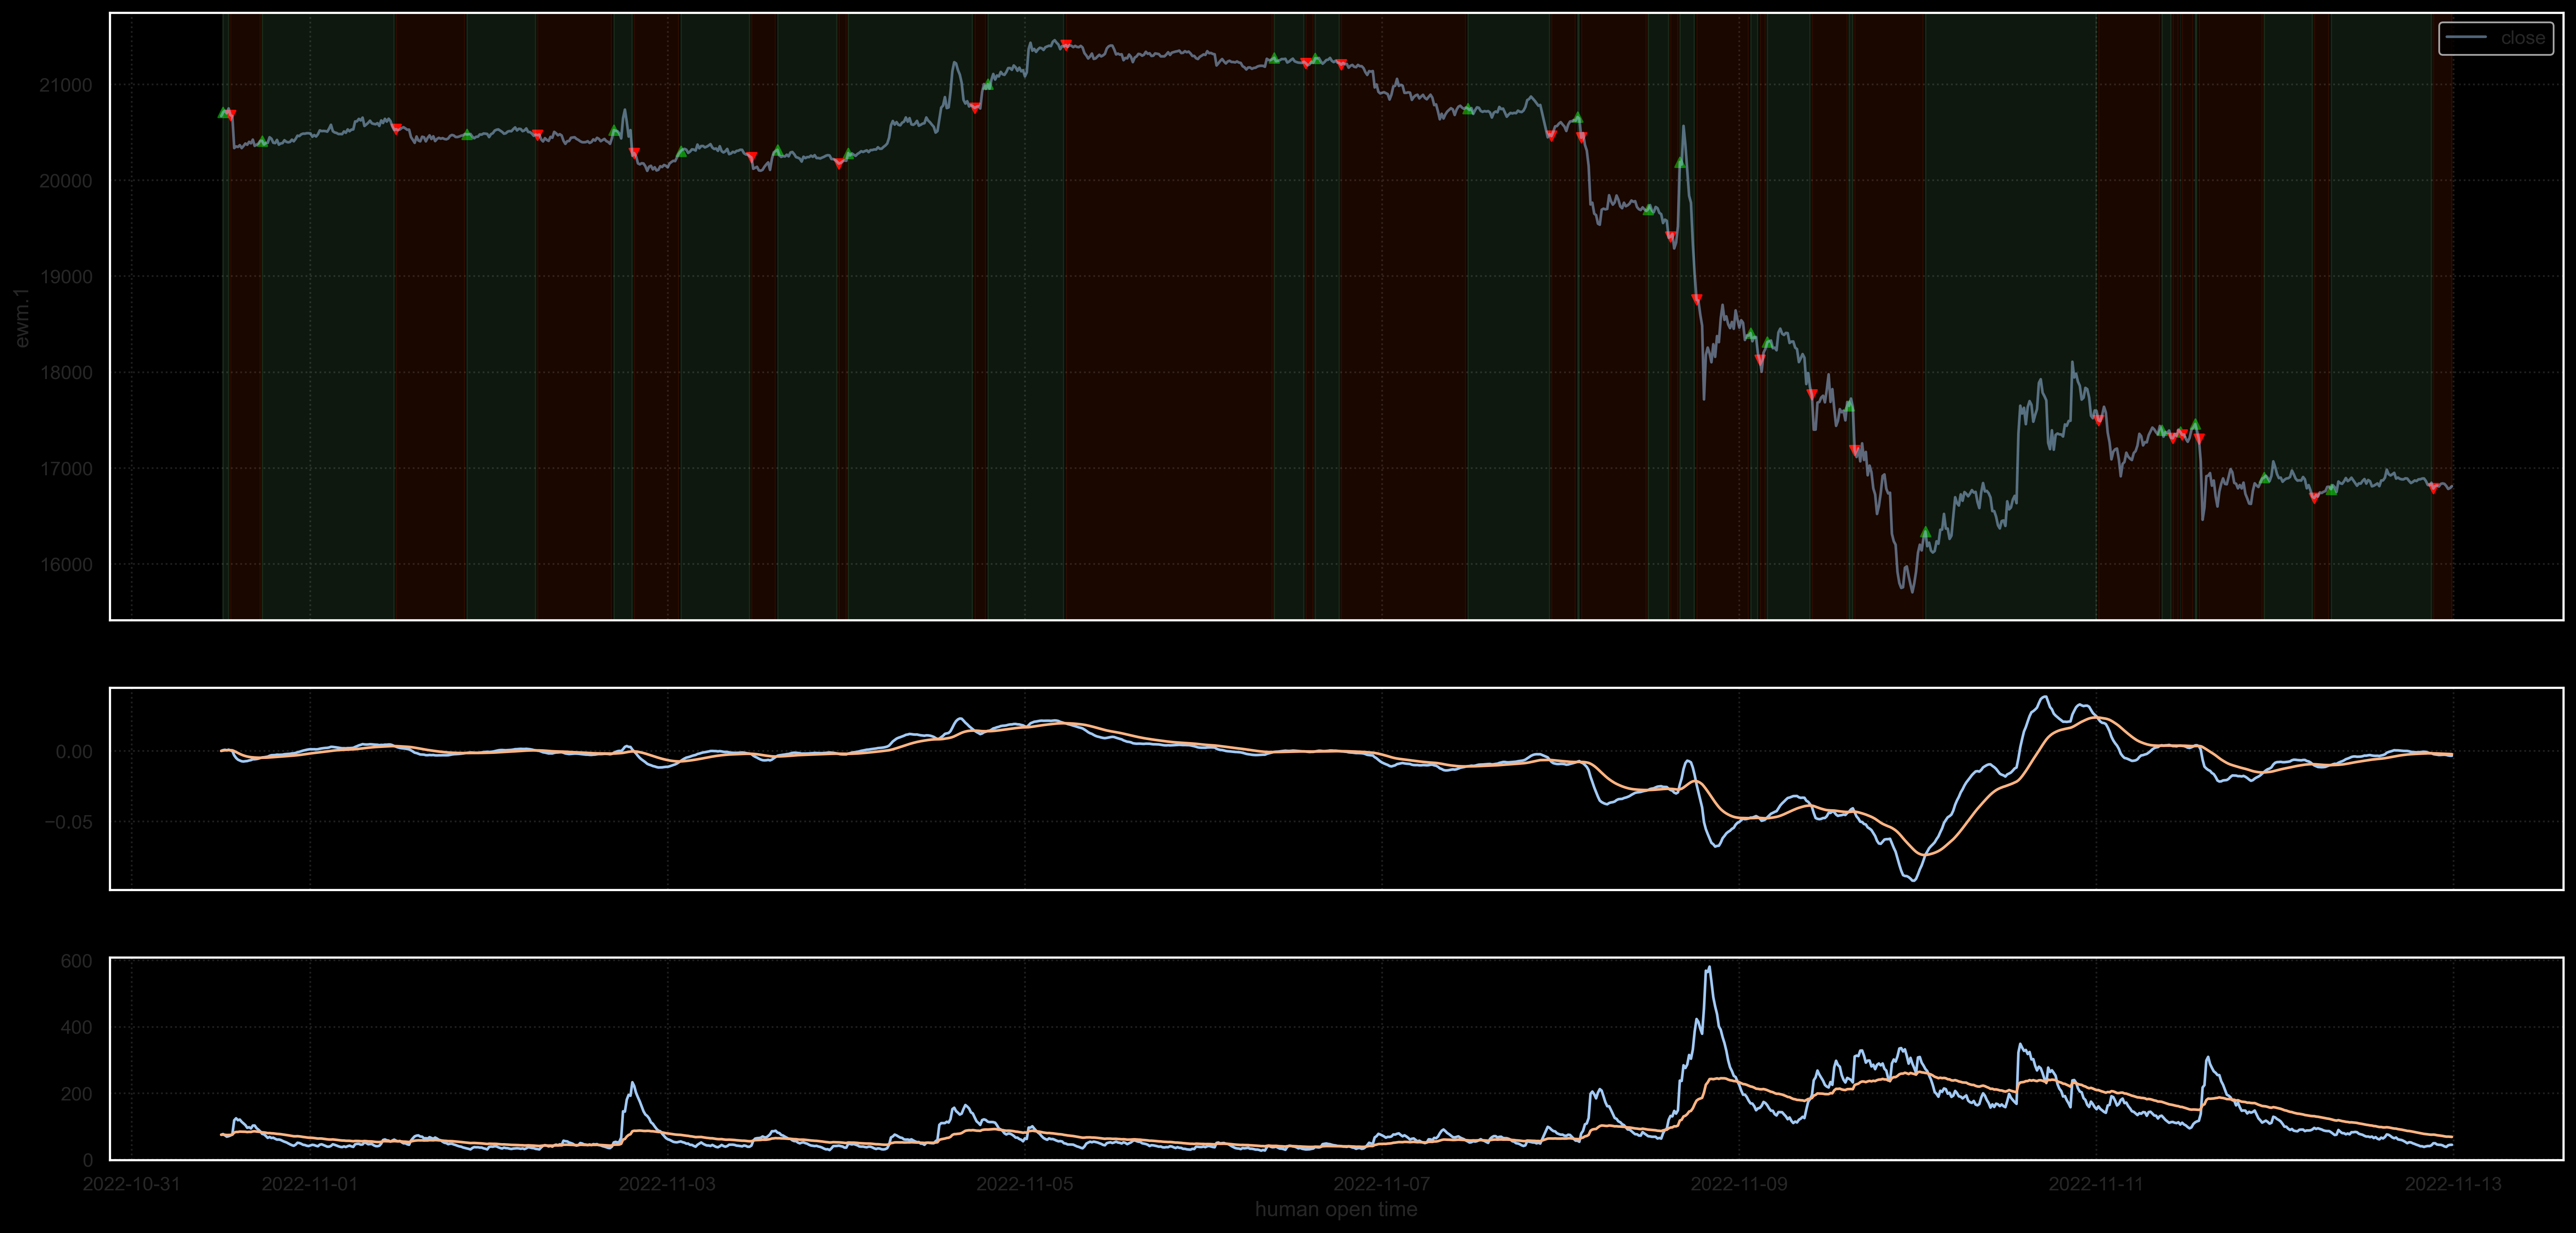

In [289]:
fig, axes = plt.subplots(3, 1, figsize=(25, 12), sharex=True, gridspec_kw={'width_ratios': [1], 'height_ratios': [6, 2, 2]})
mpl.rcParams['font.family'] = 'Ubuntu Mono'
plt.rcParams.update({"figure.dpi": 300})

# sns.set_style("darkgrid", {'axes.facecolor': 'antiquewhite', "grid.color": '#0f0f0f', "grid.linestyle": ":"})
sns.set_style("darkgrid", {'figure.facecolor': 'black', 'axes.facecolor': 'black', "grid.color": '#1f1f1f', "grid.linestyle": ":"})
sns.set_palette("pastel")
sns.set_context('notebook')

grp = s_df.groupby('event.id')
for _, group in grp:
    if group['signal'].sum() > 0: 
        axes[0].axvspan(xmin=date2num(group.index[0]), xmax=date2num(group.index[-1]), color='lightgreen', alpha=0.1) # type:ignore
    if group['signal'].sum() < 0: 
        axes[0].axvspan(xmin=date2num(group.index[0]), xmax=date2num(group.index[-1]), color='orangered', alpha=0.1) # type:ignore
    
df['long open'] = s_df['long open']
df['short open'] = s_df['short open']

markersize = 30

df['buy.price'] = np.nan
df['sell.price'] = np.nan
df.loc[df['long open'] == True, 'buy.price'] = df['ewm.1']
df.loc[df['short open'] == True, 'sell.price'] = df['ewm.1']
               
axes[0].scatter(x=df.index, y=df['buy.price'], alpha=1, marker='^', color='green', s=markersize)
axes[0].scatter(x=df.index, y=df['sell.price'], alpha=1, marker='v', color='red', s=markersize)
sns.lineplot(df['ewm.1'], label='close', ax=axes[0], alpha=0.5)
sns.lineplot(sum_diffs, ax=axes[1])
sns.lineplot(sum_diffs_smoothed, ax=axes[1])
sns.lineplot(atr, ax=axes[2])
sns.lineplot(atr_smooth, ax=axes[2])